In [5]:
import numpy as np
import matplotlib.pyplot as plt
import datacube
import datacube.virtual
from odc.ui import with_ui_cbk
from tqdm.auto import tqdm
import geopandas as gpd
import xarray as xr
import shapely.geometry
import matplotlib.colors

import sys
sys.path.insert(1, '../Scripts')
import dea_bom
import dea_bandindices
import scipy.stats
import dea_datahandling
import dea_dask

dc = datacube.Datacube(app="StreamPixelRelationships")

In [6]:
# Bourke
# southwest = (-30.27, 145.5)
# northeast = (-30.175, 145.8)

# Murray @ Colignan
# southwest = -34.57521, 142.38599
# northeast = -34.55259, 142.43062

# Murray Lock 6
southwest = (-34.52579, 144.10217)
northeast = (-34.16864, 144.33289)

ylim, xlim = zip(southwest, northeast)

## Querying the BOM

Get all stations:

In [7]:
stations = dea_bom.get_stations()

In [8]:
stations_in_range = [s for s in stations if s.pos and ylim[0] <= s.pos[0] <= ylim[1] and xlim[0] <= s.pos[1] <= xlim[1]]

In [9]:
ys, xs = zip(*[s.pos for s in stations_in_range])

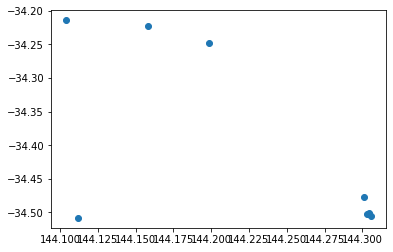

In [10]:
plt.scatter(xs, ys)

Get data for each station.

In [11]:
station_data = [dea_bom.get_station_data(s) for s in stations_in_range]

## Get TCW data for this region

TCW is better at wet vegetation than WOfS and we expect wet vegetation on floodplains, which is why we use it here.

In [12]:
ls = dea_datahandling.load_ard(dc, products=['ga_ls8c_ard_3', 'ga_ls5t_ard_3', 'ga_ls7e_ard_3'],
                          min_gooddata=0.8, x=xlim, y=ylim, output_crs='EPSG:3577', resolution=(-30, 30),
                          resampling='bilinear', measurements=['nbart_red', 'nbart_blue', 'nbart_green',
                                                               'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'])

Finding datasets
    ga_ls8c_ard_3
    ga_ls5t_ard_3
    ga_ls7e_ard_3
Counting good quality pixels for each time step
Filtering to 425 out of 1808 time steps with at least 80.0% good quality pixels
Applying pixel quality/cloud mask
Loading 425 time steps


In [13]:
tcw = dea_bandindices.calculate_indices(ls, 'TCW', 'ga_ls_3')

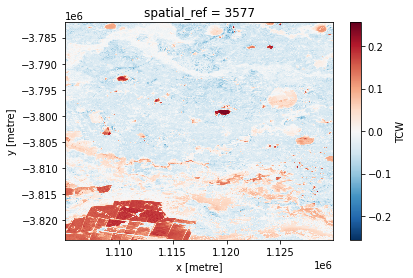

In [14]:
tcw.TCW.max(axis=0).plot()

### Reindex the BOM data to the WOfS data

Interpolate over 5 observed times, but no more, to avoid filling large periods of no data with unrealistically high values.

In [15]:
for i in range(len(station_data)):
    if len(station_data[i].index) == 0:
        continue
    times = np.sort(np.unique(np.concatenate([tcw.time, station_data[i].index])))
    station_data[i] = station_data[i].reindex(times).interpolate(method='nearest', limit=5)
    station_data[i] = station_data[i].reindex(tcw.time.values)

## Multigauge linear regression between each pixel

In [18]:
tcw_values = tcw.TCW.values.transpose(1, 2, 0)

In [16]:
from sklearn.linear_model import LinearRegression

In [19]:
slopes_lr = np.zeros((sum(1 for d in station_data if len(d.index)), tcw_values.shape[0], tcw_values.shape[1]))
station_vals = np.nan_to_num([d.values[:, 0] for d in station_data if len(d.index)])
station_vals /= station_vals.max()

In [20]:
station_vals.shape

(6, 425)

In [21]:
for y in tqdm(range(tcw_values.shape[0])):
    for x in range(tcw_values.shape[1]):
        tcw_ = np.nan_to_num(tcw_values[y, x])
        tcw_ /= abs(tcw_).max()
        lr = LinearRegression()
        lr.fit(station_vals.T, tcw_[:, None])
        slopes_lr[:, y, x] = lr.coef_.ravel()

In [27]:
station_locations = gpd.GeoDataFrame(geometry=[shapely.geometry.Point(s.pos[::-1]) for i, s in enumerate(stations_in_range) if len(station_data[i].index)], crs='EPSG:4326').to_crs(tcw.crs)

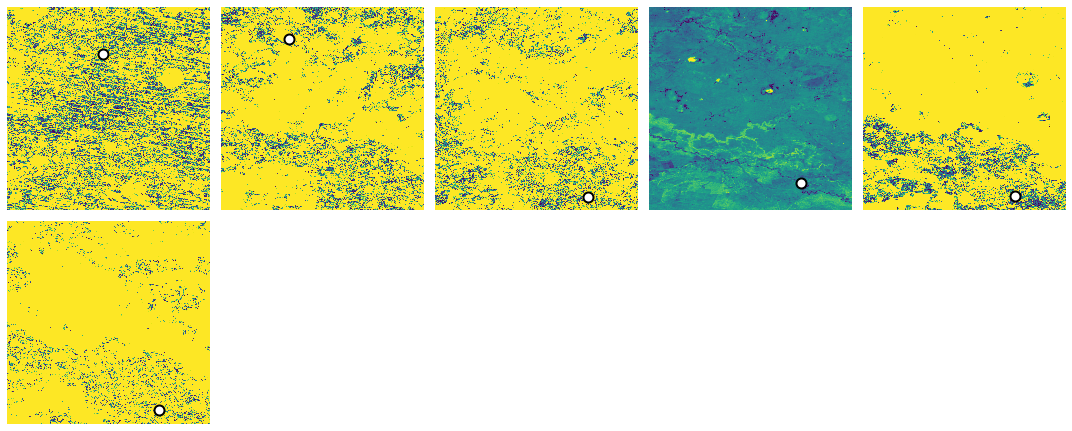

In [28]:
plt.figure(figsize=(15, 15))
for i in range(len([d for d in station_data if len(d.index)])):
    plt.subplot(5, 5, i + 1)
    plt.pcolormesh(tcw.x, tcw.y, abs(slopes_lr[i]), vmin=0, vmax=1)
    plt.scatter(station_locations.iloc[i].geometry.x, station_locations.iloc[i].geometry.y, edgecolor='k', facecolor='w', s=100, linewidth=2)
    plt.axis('off')
    
plt.tight_layout()

In [ ]:
plt.figure(figsize=(15, 7))
norm = matplotlib.colors.BoundaryNorm(range(len(station_data) + 1), len(station_data))
plt.pcolormesh(tcw.x, tcw.y, abs(slopes_lr).argmax(axis=0), cmap='Set1', norm=norm)
plt.colorbar()
plt.scatter(station_locations.geometry.x, station_locations.geometry.y, edgecolor='k', c=range(len(station_data)), s=100, linewidth=2, cmap='Set1', norm=norm)
plt.axis('off')

## Regression slope between each time series

In [174]:
tcw.TCW.values.shape

(770, 586, 913)

In [175]:
station_data[0].values.shape

(0, 1)

In [29]:
slopes = np.zeros((len(station_data), tcw_values.shape[0], tcw_values.shape[1]))
rvalues = np.zeros((len(station_data), tcw_values.shape[0], tcw_values.shape[1]))
for i in range(len(station_data)):
    if len(station_data[i].index) == 0:
        continue
    station_vals = np.nan_to_num(station_data[i].values[:, 0])
    station_vals /= station_vals.max()
    for y in tqdm(range(tcw_values.shape[0])):
        for x in range(tcw_values.shape[1]):
            tcw_ = np.nan_to_num(tcw_values[y, x])
            tcw_ /= abs(tcw_).max()
            lrr = scipy.stats.linregress(station_vals, tcw_)
            slopes[i, y, x] = lrr.slope
            rvalues[i, y, x] = lrr.rvalue

In [30]:
station_locations = gpd.GeoDataFrame(geometry=[shapely.geometry.Point(s.pos[::-1]) for s in stations_in_range], crs='EPSG:4326').to_crs(tcw.crs)

In [31]:
station_locations.iloc[0].geometry.x

1116785.4576503793

/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


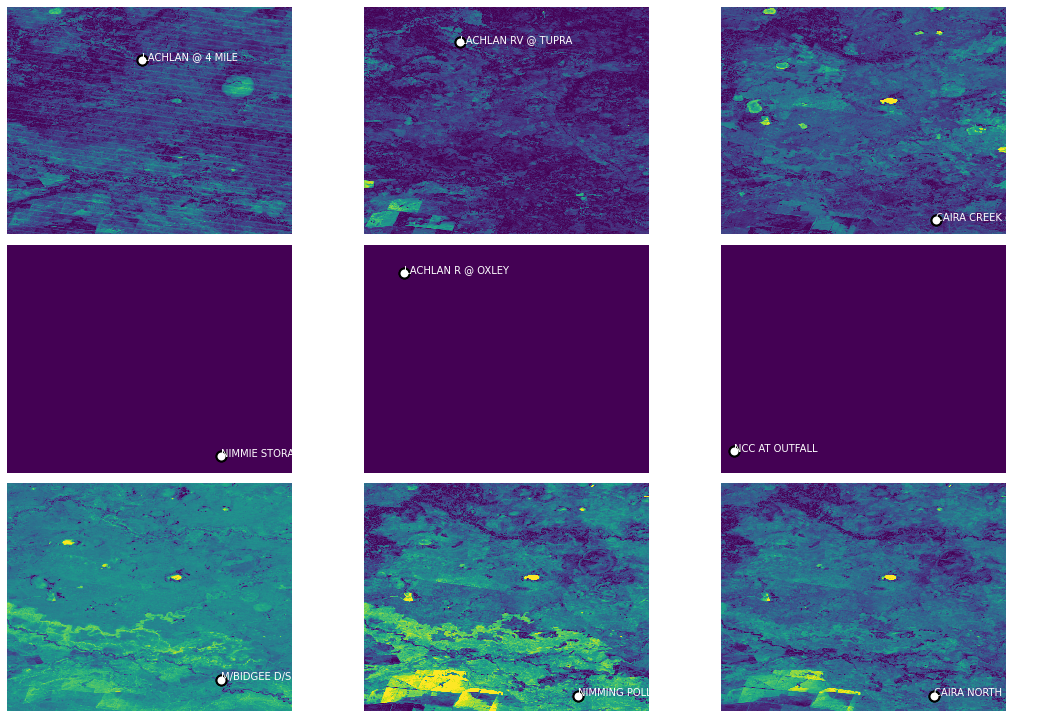

In [34]:
plt.figure(figsize=(15, 20))
for i in range(len(station_data)):
    plt.subplot(6, 3, i + 1)
    plt.pcolormesh(tcw.x, tcw.y, abs(slopes[i]), vmin=0, vmax=1)
    plt.scatter(station_locations.iloc[i].geometry.x, station_locations.iloc[i].geometry.y, edgecolor='k', facecolor='w', s=100, linewidth=2)
    plt.axis('off')
for i in range(len(station_data)):
    plt.subplot(6, 3, i + 1)
    plt.scatter(station_locations.iloc[i].geometry.x, station_locations.iloc[i].geometry.y, edgecolor='k', facecolor='w', s=100, linewidth=2)
    plt.text(station_locations.iloc[i].geometry.x, station_locations.iloc[i].geometry.y, stations_in_range[i].name, c='white')
    
plt.tight_layout()

(1105035.0, 1129875.0, -3823725.0, -3782085.0)

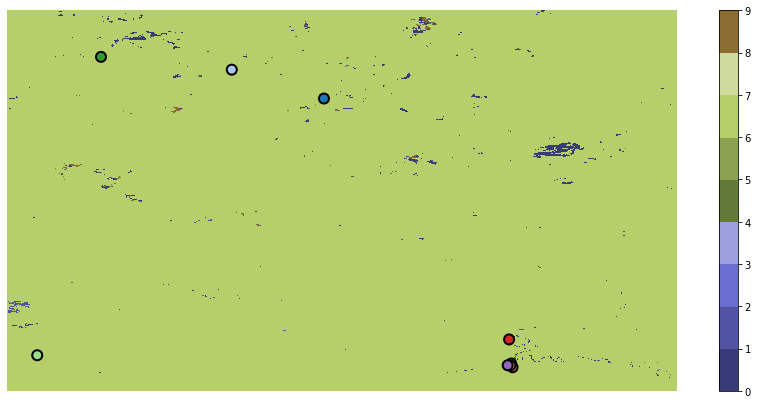

In [35]:
plt.figure(figsize=(15, 7))
norm = matplotlib.colors.BoundaryNorm(range(len(station_data) + 1), len(station_data))
plt.pcolormesh(tcw.x, tcw.y, abs(rvalues).argmax(axis=0), cmap='tab20b', norm=norm)
plt.colorbar()
plt.scatter(station_locations.geometry.x, station_locations.geometry.y, edgecolor='k', c=range(len(station_data)), s=100, linewidth=2, cmap='tab20', norm=norm)
plt.axis('off')

## Determine the minimum stream gauge level that each pixel fills at

For each pixel and each stream gauge, determine the minimum stream gauge level for all times it was full at.

In [ ]:
has_water.shape

In [ ]:
minima.shape

In [183]:
minima = np.ones((len(station_data), water.shape[1], water.shape[2])) * np.inf
for time in tqdm(water.time):
    time = time.values
    has_water = water.sel(time=time)
    stream_data = [d.loc[time] for d in station_data]
    for i, s in enumerate(stream_data):
        if np.isnan(s.values):
            continue
        minima[i, has_water] = np.minimum(minima[i, has_water], s.values)

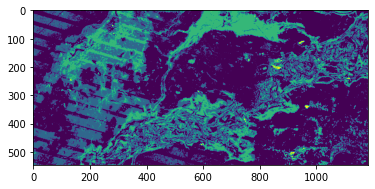

In [196]:
plt.imshow(np.argmin(minima, axis=0))

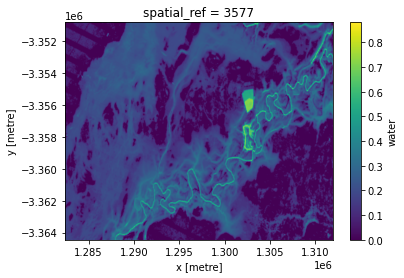

In [189]:
(water.mean(dim='time') ** 0.3).plot.imshow(interpolation='gaussian')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:**

In [187]:
datacube.__version__

'1.8.3'

## Tags